In [1]:
#install required library first
! pip install -q kaggle 
from google.colab import files
files.upload() #upload api keys from kaggle, use your own api keys

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"sadhityadimas","key":"d3806d359f5c69610aab5929246ed1a9"}'}

In [ ]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets list

In [3]:
# Download dataset from kaggle
! kaggle datasets download -d abdalnassir/chicken-breeds

 40% 5.00M/12.6M [00:00<00:00, 51.2MB/s]
100% 12.6M/12.6M [00:00<00:00, 62.0MB/s]


In [ ]:
! mkdir chicken
! unzip /content/chicken-breeds.zip -d chicken

In [5]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping
from keras.preprocessing import image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
from google.colab import files
import zipfile,os 
import pandas as pd
import pickle as pkl

In [ ]:
!pip install split_folders tqdm #for dataset train test split 
!pip install seedir #for directory treeview 
import splitfolders #for easier dataset splitting  
import seedir as sd #for directory tree viewer

In [7]:
#target directory
target_dir = '/content/chicken/Chicken Breeds'

In [8]:
sd.seedir(target_dir, style='lines', itemlimit=4, depthlimit=3)

Chicken Breeds/
├─training/
│ ├─American Gamefowl/
│ │ ├─confidence-0.11764706-time-1620458942192.jpg
│ │ ├─1606453950230.jpg
│ │ ├─1607014942554.jpg
│ │ └─1602195937183.jpg
│ ├─Speckled Sussex/
│ │ ├─11401475_706693912797011_1356674891240459996_n.jpg
│ │ ├─1605047930493.jpg
│ │ ├─104201572_10221478511766719_4717893100809827444_o.jpg
│ │ └─122230466_10224512732547388_5863994209712976213_o.jpg
│ ├─Wyandotte/
│ │ ├─portrait-domesticated-wyandotte-hen-seen-260nw-1720259425.jpg
│ │ ├─pair-show-quality-wyandotte-hens-260nw-608697689.jpg
│ │ ├─profile-golden-wyandotte-isolated-on-260nw-395592337.jpg
│ │ └─silverlaced-wyandotte-chicken-front-white-260nw-1064346017.jpg
│ └─Sapphire Gem/
│   ├─1600107680739.jpg
│   ├─confidence-0.12156863-time-1614580573255.jpg
│   ├─1595183832082.jpg
│   └─confidence-0.33333334-time-1620946199751.jpg
└─validation/
  ├─American Gamefowl/
  │ ├─confidence-0.26666668-time-1613275088717.jpg
  │ ├─1601215625189.jpg
  │ ├─confidence-0.13725491-time-1615800898035.jpg

In [34]:
#count total files in train and validation set 
split_path = '/content/chicken/Chicken Breeds/'
folder_names = ['Chick', 'Speckled Sussex', 'American Gamefowl', 'Sapphire Gem', 'Wyandotte']

original_files ={}
train_files = {}
val_files = {}

for i in folder_names:
    train_files[i] = len(os.listdir(split_path+'training/'+i))
    val_files[i] = len(os.listdir(split_path+'validation/'+i))

    
#convert to dataframe for easier comprehension
result_split = pd.DataFrame()
result_split = result_split.append(train_files, ignore_index=True)
result_split = result_split.append(val_files, ignore_index=True)
result_split['total'] = result_split.sum(axis=1)
result_split['type'] = ['train', 'val']
result_split = result_split[['type', 'Chick', 'Speckled Sussex', 'American Gamefowl', 'Sapphire Gem', 'Wyandotte', 'total']]
print(result_split)
print(result_split.to_markdown(index=False))

    type  Chick  Speckled Sussex  ...  Sapphire Gem  Wyandotte  total
0  train  164.0            164.0  ...         164.0      200.0  860.0
1    val   36.0             36.0  ...          36.0       59.0  203.0

[2 rows x 7 columns]
| type   |   Chick |   Speckled Sussex |   American Gamefowl |   Sapphire Gem |   Wyandotte |   total |
|:-------|--------:|------------------:|--------------------:|---------------:|------------:|--------:|
| train  |     164 |               164 |                 168 |            164 |         200 |     860 |
| val    |      36 |                36 |                  36 |             36 |          59 |     203 |


Image shape (224, 224, 3)
Image shape (224, 224, 3)
Image shape (224, 224, 3)
Image shape (224, 224, 3)
Image shape (224, 224, 3)
Image shape (224, 224, 3)
Image shape (224, 224, 3)
Image shape (224, 224, 3)
Image shape (224, 224, 3)
Image shape (224, 224, 3)
Image shape (224, 224, 3)
Image shape (224, 224, 3)
Image shape (224, 224, 3)
Image shape (224, 224, 3)
Image shape (224, 224, 3)
Image shape (224, 224, 3)
Image shape (224, 224, 3)
Image shape (224, 224, 3)
Image shape (224, 224, 3)
Image shape (224, 224, 3)


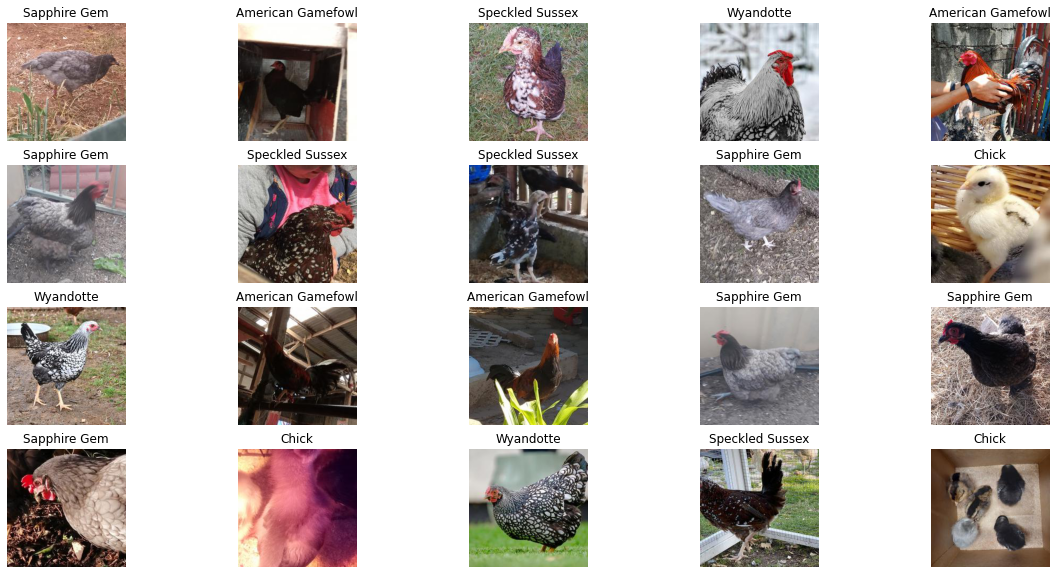

In [10]:
#Display random images
import random

#function for displaying 1 random image and image shape
def one_random_image(target_path, target_class): 
  target_fold = target_path + target_class
  random_image = random.sample(os.listdir(target_fold), 1)
  image = mpimg.imread(target_fold+'/'+random_image[0])
  plt.imshow(image)
  plt.title(target_class)
  plt.axis('off');
  print(f"Image shape {image.shape}")

  return image

#Function for displaying group of random images and shape
def group_random_images( target_path, figure_size=(20, 10), group=20):
  plt.figure(figsize=figure_size)
  for i in range(group):
    plt.subplot(4, 5, i+1)
    class_name = random.choice(['Chick', 'Speckled Sussex', 'American Gamefowl', 'Sapphire Gem', 'Wyandotte'])
    image = one_random_image(target_path=target_path, target_class=class_name)
  
group_random_images = group_random_images(target_path='/content/chicken/Chicken Breeds/training/')

In [11]:
## saving train and validation path into variable
train_set = '/content/chicken/Chicken Breeds/training'
val_set = '/content/chicken/Chicken Breeds/validation'

In [12]:
#image augmentation
#training set rescale and augmenting
train_aug = ImageDataGenerator(
                    rescale=1./255,
                    rotation_range=30,
                    horizontal_flip=True,
                    zoom_range=0.2,
                    shear_range = 0.2,
                    fill_mode = 'nearest')

#only rescale the validation set, dont do the augmentation step for validation set, it might cause bias
valid_aug = ImageDataGenerator(rescale=1./255)

In [13]:
#train and validation data generator
#batch size 64
#class mode is categorical since we have 5 classes
train_generator = train_aug.flow_from_directory(
        train_set,  
        target_size=(128, 128),  
        class_mode='categorical')

validation_generator = valid_aug.flow_from_directory(
        val_set, 
        target_size=(128, 128), 
        class_mode='categorical')

Found 860 images belonging to 5 classes.
Found 203 images belonging to 5 classes.


In [14]:
#building model 
#using 2 hidden layer 
#using softmax in output layer instead of sigmoid because there are 5 outcomes
model = keras.Sequential([
    layers.Conv2D(32, (3,3), activation = 'relu', input_shape= (128,128,3)),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.Conv2D(64,(3,3), activation= 'relu'),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.Conv2D(128,(3,3), activation= 'relu'),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.Flatten(),
    layers.Dropout(0.5),
    layers.Dense(128, activation= 'relu'),
    layers.Dense(5, activation= 'softmax') 
])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 126, 126, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 63, 63, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 61, 61, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 30, 30, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 28, 28, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 14, 14, 128)      0

In [15]:

# Adding lose function and optimizer
#categorical since we have 5 classes
#using adam 
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [16]:
# callback
class myCallback(keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('val_accuracy') >= 0.85):
      self.model.stop_training = True
      print("\nValidation Accuracy of the model >= 85%")
early_stop = myCallback()

In [17]:
# Training the model
history = model.fit(
    train_generator,
    epochs=40, 
    validation_data = validation_generator,
    verbose = 1,
    callbacks=[early_stop]
)

Epoch 1/40
27/27 [==============================] - 39s 1s/step - loss: 1.6147 - accuracy: 0.2384 - val_loss: 1.4464 - val_accuracy: 0.3448
Epoch 2/40
27/27 [==============================] - 27s 1s/step - loss: 1.3606 - accuracy: 0.4000 - val_loss: 1.0884 - val_accuracy: 0.5961
Epoch 3/40
27/27 [==============================] - 27s 1s/step - loss: 1.1523 - accuracy: 0.5419 - val_loss: 1.0382 - val_accuracy: 0.6256
Epoch 4/40
27/27 [==============================] - 27s 998ms/step - loss: 0.9979 - accuracy: 0.5988 - val_loss: 0.8404 - val_accuracy: 0.7044
Epoch 5/40
27/27 [==============================] - 29s 1s/step - loss: 0.9226 - accuracy: 0.6419 - val_loss: 0.6513 - val_accuracy: 0.8030
Epoch 6/40
27/27 [==============================] - 27s 1s/step - loss: 0.8752 - accuracy: 0.6547 - val_loss: 0.7217 - val_accuracy: 0.7241
Epoch 7/40
27/27 [==============================] - 27s 1s/step - loss: 0.8213 - accuracy: 0.6802 - val_loss: 0.8307 - val_accuracy: 0.7143
Epoch 8/40
27/27 

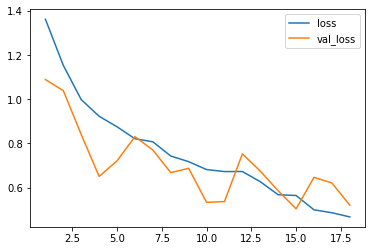

In [18]:
#loss 
history_df = pd.DataFrame(history.history)
history_df.loc[1:, ['loss', 'val_loss']].plot()
plt.show()

In [ ]:
#accuracy 
history_df.loc[1:, ['accuracy', 'val_accuracy']].plot()
plt.show()

In [20]:
#Best validation loss and accuracy score
print(("Best Validation Loss: {:0.2f}" +"\nBest Validation Accuracy: {:0.2f}").format(history_df['val_loss'].min(), history_df['val_accuracy'].max()))

Best Validation Loss: 0.50
Best Validation Accuracy: 0.86


In [30]:
# Save the trained model 
model.save('my_model.h5', include_optimizer=False)

In [31]:
# check if the saved model works
# Recreate the exact same model, including its weights and the optimizer
new_model = tf.keras.models.load_model('my_model.h5')

# Show the model architecture
new_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 126, 126, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 63, 63, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 61, 61, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 30, 30, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 28, 28, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 14, 14, 128)      0

Saving unnamed.jpg to unnamed (1).jpg
unnamed.jpg


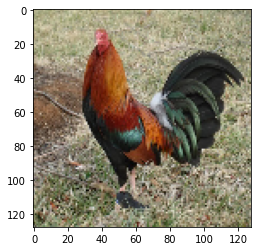

In [32]:
#try to predict
upload_file = files.upload()
 
for file_name in upload_file.keys():
 
  # predicting images
  file_path = file_name
  img = image.load_img(file_path, target_size=(128,128))
  imgplot = plt.imshow(img)
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)
 
  images = np.vstack([x])
  predict = new_model.predict(images, batch_size=10)
  print(file_name)
  predict

In [33]:
#try the prediction
if predict[0][0] == 1.:
  print('American Gamefowl')
elif predict[0][1] == 1.:
  print('Chick')
elif predict[0][2] == 1.:
  print('Sapphire Gem')
elif predict[0][3] == 1.:
  print('Speckled Sussex')    
else:
  print('Wyandotte')


American Gamefowl


In [ ]:
#Success

In [26]:
#save the model in pickle
pkl.dump(model, open('model.pkl', 'wb'))

INFO:tensorflow:Assets written to: ram://734bd73f-cc20-4281-a3d9-5bcd8fc5a9dd/assets


Saving download.jpg to download.jpg
download.jpg


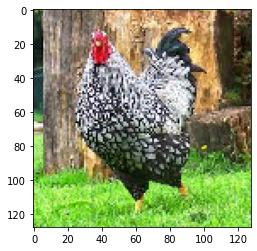

In [28]:
pickled_model = pkl.load(open('model.pkl', 'rb'))

#try to predict
upload_file = files.upload()
 
for file_name in upload_file.keys():
 
  # predicting images
  file_path = file_name
  img = image.load_img(file_path, target_size=(128,128))
  imgplot = plt.imshow(img)
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)
 
  images = np.vstack([x])
  predict = pickled_model.predict(images, batch_size=10)
  print(file_name)
  predict

In [29]:
#try the prediction
if predict[0][0] == 1.:
  print('American Gamefowl')
elif predict[0][1] == 1.:
  print('Chick')
elif predict[0][2] == 1.:
  print('Sapphire Gem')
elif predict[0][3] == 1.:
  print('Speckled Sussex')    
else:
  print('Wyandotte')

Wyandotte
